# Testing divide and conquer

Summary: works well if extraction wavelength step size isn't too small.

In [1]:
from specter.extract import ex2d
import numpy as np
import desimodel.io
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
psf = desimodel.io.load_psf('r')

## Testing a noisy image with no signal

In [3]:
readnoise = 2.5
img = np.random.normal(size=(psf.npix_y, psf.npix_x), scale=readnoise)
imgivar = np.ones_like(img)/readnoise**2

In [4]:
ww = np.arange(7000, 7060, 1)
flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, 10, ww, wavesize=30)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, 10, ww, wavesize=15)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

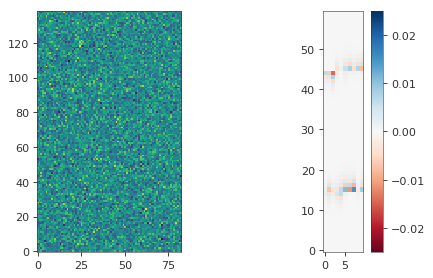

In [5]:
xmin, xmax, ymin, ymax = psf.xyrange([0,10], ww)
subplot(121)
imshow(img[ymin:ymax, xmin:xmax])
subplot(122)
imshow(((flux1-flux2)/fluxerr).T, cmap='RdBu', vmin=-0.025, vmax=0.025); colorbar()

## Test noisy image with signal

In [6]:
influx = np.random.uniform(0, 1000, size=(10, len(ww)))
noiseless_img = psf.project(ww, influx)
imgvar = readnoise + noiseless_img
img = noiseless_img + np.random.normal(scale=np.sqrt(imgvar))
imgivar = 1/imgvar

In [7]:
ww = np.arange(7000, 7060, 1)
flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, 10, ww, wavesize=30)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, 10, ww, wavesize=15)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

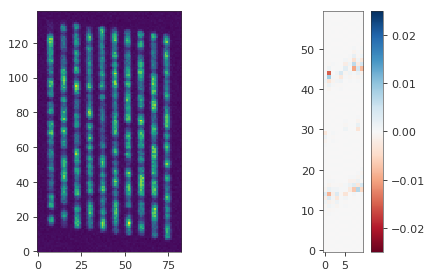

In [8]:
xmin, xmax, ymin, ymax = psf.xyrange([0,10], ww)
subplot(121)
imshow(img[ymin:ymax, xmin:xmax])
subplot(122)
imshow(((flux1-flux2)/fluxerr).T, cmap='RdBu', vmin=-0.025, vmax=0.025); colorbar()

## Recreate specter.test.test_extract

Note that differences are now ${\cal O}(1\sigma)$ instead of ${\cal O}(0.01\sigma)$

In [9]:
from pkg_resources import resource_filename
import specter.psf
testpsf = specter.psf.load_psf(resource_filename("specter.test", "t/psf-spot.fits"))

In [10]:
np.random.seed(0)
nspec = 10
wmin = min(testpsf.wavelength(0, y=0), testpsf.wavelength(nspec-1, y=0))
wmin, wmax = testpsf.wavelength(0, y=(10,90))
ww = np.arange(wmin, wmax, 0.5)
nwave = len(ww)

phot_shape = (nspec, nwave)
phot = np.random.uniform(1, 1000, size=phot_shape)
image_orig = testpsf.project(ww, phot, verbose=False)
var = 1.0 + image_orig
img = image_orig + np.random.normal(scale=np.sqrt(var))
imgivar = 1/var

In [11]:
flux1, ivar1, Rdata1 = ex2d(img, imgivar, testpsf, 0, nspec, ww, wavesize=len(ww)//5, nsubbundles=1)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, testpsf, 0, nspec, ww, wavesize=len(ww)//2, nsubbundles=2)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

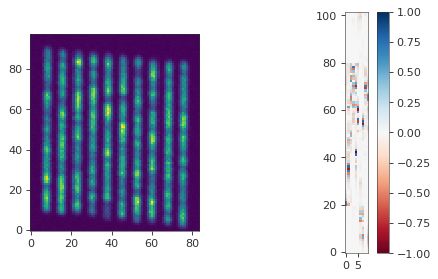

In [12]:
xmin, xmax, ymin, ymax = testpsf.xyrange([0,10], ww)
subplot(121)
imshow(img[ymin:ymax, xmin:xmax])
subplot(122)
imshow(((flux1-flux2)/fluxerr).T, cmap='RdBu', vmin=-1, vmax=1); colorbar()

## Adapt original example to be more like test
Still has large deviations

In [13]:
np.random.seed(0)
wmin, wmax = psf.wavelength(0, y=(10,90))
ww = np.arange(wmin, wmax, 0.5)
nwave = len(ww)

phot_shape = (nspec, nwave)
phot = np.random.uniform(1, 1000, size=phot_shape)
image_orig = psf.project(ww, phot, verbose=False)
var = 1.0 + image_orig
img = image_orig + np.random.normal(scale=np.sqrt(var))
imgivar = 1/var

In [14]:
flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, nspec, ww, wavesize=len(ww)//5, nsubbundles=1)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, nspec, ww, wavesize=len(ww)//2, nsubbundles=2)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

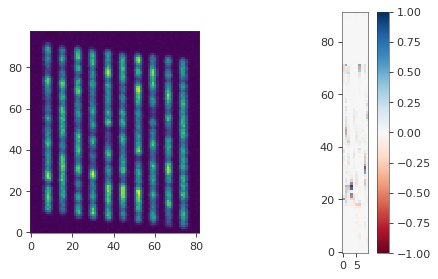

In [15]:
xmin, xmax, ymin, ymax = psf.xyrange([0,10], ww)
subplot(121)
imshow(img[ymin:ymax, xmin:xmax])
subplot(122)
imshow(((flux1-flux2)/fluxerr).T, cmap='RdBu', vmin=-1, vmax=1); colorbar()

## Difference is extraction step size

In [16]:
wmin = psf.wavelength(0, y=10)
wmax = wmin + 60
wsteps = (0.5, 0.6, 0.7, 0.8, 0.9, 1.0)
maxdiff = list()
for wstep in wsteps:
    ww = np.arange(wmin, wmax, wstep)
    nwave = len(ww)
    phot_shape = (nspec, nwave)
    phot = np.random.uniform(1, 1000, size=phot_shape)
    image_orig = psf.project(ww, phot, verbose=False)
    var = 1.0 + image_orig
    img = image_orig + np.random.normal(scale=np.sqrt(var))
    imgivar = 1/var

    flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, nspec, ww, wavesize=len(ww)//5)
    flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, nspec, ww, wavesize=len(ww)//2)
    fluxerr = np.sqrt(1/ivar1 + 1/ivar2)
    
    maxdiff.append(np.max(np.abs((flux1-flux2)/fluxerr)))

(0, 1)

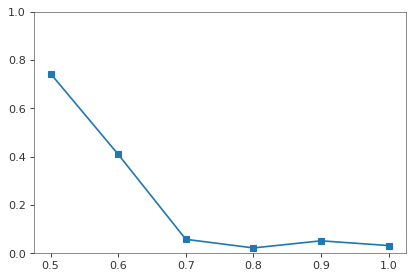

In [17]:
plot(wsteps, maxdiff, 's-')
ylim(0, 1)

In [18]:
maxdiff

[0.74353919745465424,
 0.40916469153960894,
 0.057594007594515689,
 0.021896327891030548,
 0.051340086472699553,
 0.031739446035328897]

# Timing tests for subbundle extraction

In [19]:
#- Make sure we have right PSF
psf = desimodel.io.load_psf('r')
ww = np.arange(7000, 7200, 1)

In [20]:
readnoise = 2.5
img = np.random.normal(size=(psf.npix_y, psf.npix_x), scale=readnoise)
imgivar = np.ones_like(img)/readnoise**2

In [21]:
extime = list()
nsubbundles = (1,2,3,4,5)
for n in nsubbundles:
    t0 = time.time()
    flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, 25, ww, nsubbundles=n)
    dt = time.time() - t0
    extime.append(dt)
    print('{:2d} {:.1f}'.format(n, dt))

 1 25.6
 2 13.2
 3 10.7
 4 10.4
 5 10.2


In [22]:
exrate = 25*len(ww)/np.array(extime)

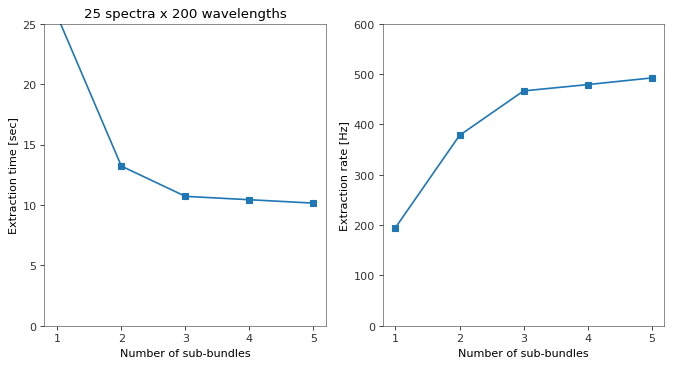

In [23]:
figure(figsize=(10,5))
subplot(121)
plot(nsubbundles, extime, 's-')
ylim(0, 25)
ylabel('Extraction time [sec]')
xticks(nsubbundles, nsubbundles)
xlabel('Number of sub-bundles')
title('25 spectra x 200 wavelengths')

subplot(122)
plot(nsubbundles, exrate, 's-')
ylim(0, 600)
ylabel('Extraction rate [Hz]')
xticks(nsubbundles, nsubbundles)
xlabel('Number of sub-bundles')
savefig('subbundle-speed.png')

In [24]:
np.max(exrate) / np.min(exrate)

2.5251462652578143

In [25]:
exrate / exrate[0]

array([ 1.        ,  1.9397157 ,  2.39304556,  2.45740015,  2.52514627])

## More examples

In [26]:
ww = np.arange(7000, 7090, 1)
readnoise = 2.5
influx = np.random.uniform(0, 100, size=(25, len(ww)))
noiseless_img = psf.project(ww, influx)
imgvar = readnoise + noiseless_img
img = noiseless_img + np.random.normal(scale=np.sqrt(imgvar))
imgivar = 1/imgvar

flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, 25, ww, wavesize=60, nsubbundles=1)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, 25, ww, wavesize=30, nsubbundles=2)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

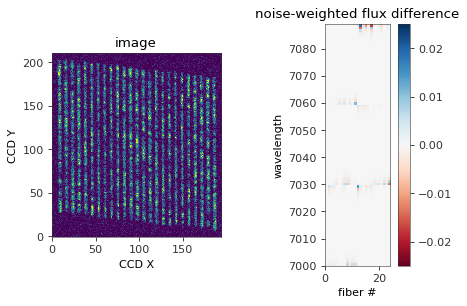

In [27]:
xmin, xmax, ymin, ymax = psf.xyrange([0,25], ww)

subplot(121)
imshow(img[ymin:ymax, xmin:xmax], vmin=0, vmax=20, cmap='viridis')
title('image')
xlabel('CCD X')
ylabel('CCD Y')

subplot(122)
imshow(((flux1-flux2)/fluxerr).T, vmin=-0.025, vmax=0.025, cmap='RdBu',
    extent=(0,24, ww[0], ww[-1]))
title('noise-weighted flux difference')
xlabel('fiber #')
ylabel('wavelength')
colorbar()
savefig('divide-and-conquer-residuals.png')

## Test worst case of a bright fiber being on the edge

In [40]:
ww = np.arange(7000, 7060, 1)
readnoise = 2.5
influx = np.random.uniform(0, 1000, size=(20, len(ww)))
influx[10] += 1000
influx[10, 30] += 5000
influx[:, 20] += 5000
influx[:, 40] += 10000
noiseless_img = psf.project(ww, influx)
imgvar = readnoise + noiseless_img
img = noiseless_img + np.random.normal(scale=np.sqrt(imgvar))
imgivar = 1/imgvar

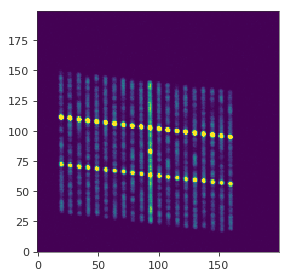

In [41]:
imshow(img[2600:2800, 150:350], vmin=0, vmax=400)

Extract the full 25 spectra x 60 wavelengths, and then repeat with just the first
10 spectra (bright fiber just off the edge) and 11 spectra (includes the bright fiber)
and compare whether the bright edge fiber affected the results

In [43]:
flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, 20, ww, wavesize=60)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, 10, ww, wavesize=30)
flux3, ivar3, Rdata3 = ex2d(img, imgivar, psf, 0, 11, ww, wavesize=30)

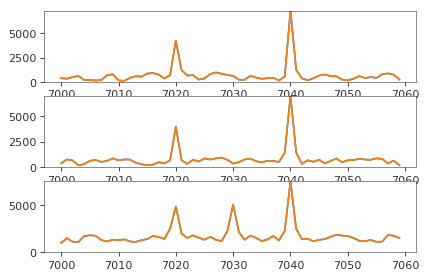

In [54]:
for i in [8,9,10]:
    subplot(3,1,1+i-8)
    plot(ww, flux1[i])
    plot(ww, flux3[i])
    ylim(0, np.max(flux1[i]))

If you don't include the extra boundary fiber, the last fiber of the subbundle has a small
systematic bias.  If you include it, then there are individual pixels that are biased but not
an overall offset systematic bias.

(-0.025, 0.025)

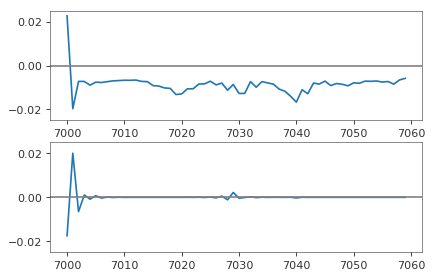

In [53]:
#- Was fiber 9 affected by the bright fiber 10?
subplot(211)
dflux = (flux1[9] - flux2[9]) / np.sqrt(1/ivar1[9] + 1/ivar2[9])
plot(ww, dflux)
ylim(-0.025, 0.025)
axhline(0, color='0.5')
subplot(212)
dflux = (flux1[9] - flux3[9]) / np.sqrt(1/ivar1[9] + 1/ivar3[9])
plot(ww, dflux)
axhline(0, color='0.5')
ylim(-0.025, 0.025)